In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import stats
from tqdm.auto import tqdm

In [7]:
df = pd.read_csv('hw_aa.csv',sep=';')

In [8]:
df=df.drop('Unnamed: 0', axis=1)

In [9]:
df.head()

,uid,experimentVariant,version,purchase
0,c4ca4238a0b923820dcc509a6f75849b,1,v2.8.0,0
1,c81e728d9d4c2f636f067f89cc14862c,0,v2.9.0,0
2,eccbc87e4b5ce2fe28308fd9f2a7baf3,1,v2.9.0,0
3,a87ff679a2f3e71d9181a67b7542122c,1,v2.8.0,0
4,e4da3b7fbbce2345d7772b0674a318d5,1,v2.8.0,0


In [10]:
df.version.value_counts()

v2.8.0      82835
v2.9.0      23954
v3.8.0.0    11804
v3.7.4.0     8425
Name: version, dtype: int64

In [11]:
df.experimentVariant.value_counts()

1    63916
0    63102
Name: experimentVariant, dtype: int64

In [12]:
df.purchase.value_counts()

0    122104
1      4914
Name: purchase, dtype: int64

## Разделим на группы и запустим A/A-тест

In [13]:
df_0 = df.query('experimentVariant == 0')
df_1 = df.query('experimentVariant == 1')

In [14]:
# обернём А/А тест в функцию
def aa_test(ser_1, ser_2, simulations = 1000, n_s = 1000):
    res = []

    # запуск симуляций A/A теста
    for i in tqdm(range(simulations)):
        s1 = ser_1.sample(n_s, replace = False).values
        s2 = ser_2.sample(n_s, replace = False).values
        res.append(stats.mannwhitneyu(s1, s2)[1])       # сохраняем pvalue

    plt.hist(res, bins = 50)
    plt.style.use('ggplot')
    plt.xlabel('pvalues')
    plt.ylabel('frequency')
    plt.title("Histogram of mannwhitneyu A/A simulations ")
    plt.show()

    # Проверяем, что количество ложноположительных случаев не превышает альфа
    return sum(np.array(res) <0.05) / simulations

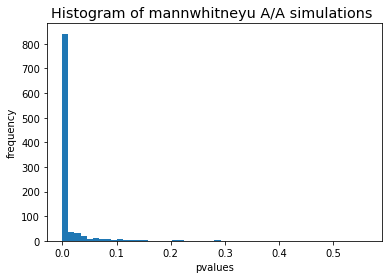

0.933

In [15]:
aa_test(df_0['purchase'], df_1['purchase'])

А/А тест показывает, что в более 94% случаев симуляций выборки различаются

`FPR > 0.05`, т.е. доля ложноположительных оценок (доля симуляций, в которых был получен `p < 0.05`) составляет больше `5%`, причем значительно больше. Таким образом, в подавляющем большинстве случаев мы получаем статистически значимые различия между двумя группами, которых на самом деле быть не должно. Значит, что-то пошло не так, и необходимо искать причину поломки.

## Ищем поломку
Сгруппируем наш датасет по номеру группы и посчитаем конверсию.

In [16]:
df_grouped = df.groupby('experimentVariant',as_index=False).agg({'uid': 'count', 'purchase': 'sum'})
df_grouped

,experimentVariant,uid,purchase
0,0,63102,1511
1,1,63916,3403


In [17]:
df_grouped['conversion'] = df_grouped['purchase'] / df_grouped['uid']
df_grouped

,experimentVariant,uid,purchase,conversion
0,0,63102,1511,0.023945
1,1,63916,3403,0.053242


Количество пользователей в двух группах примерно одинаковое, однако конверсия в нулевой группе заметно ниже, чем в первой. Пока что это согласуется с результатом А/А-теста.

Теперь сгруппируем наш датасет по номеру группы и версии мобильного приложения и посчитаем конверсию для каждой подгруппы.

In [18]:
df_grouped_ver = df.groupby(['experimentVariant', 'version'],as_index=False).agg({'uid': 'count', 'purchase': 'sum'})
df_grouped_ver

,experimentVariant,version,uid,purchase
0,0,v2.8.0,41283,41
1,0,v2.9.0,11921,890
2,0,v3.7.4.0,4204,252
3,0,v3.8.0.0,5694,328
4,1,v2.8.0,41552,1895
5,1,v2.9.0,12033,858
6,1,v3.7.4.0,4221,266
7,1,v3.8.0.0,6110,384


In [19]:
df_grouped_ver['conversion'] = df_grouped_ver['purchase'] / df_grouped_ver['uid']
df_grouped_ver

,experimentVariant,version,uid,purchase,conversion
0,0,v2.8.0,41283,41,0.000993
1,0,v2.9.0,11921,890,0.074658
2,0,v3.7.4.0,4204,252,0.059943
3,0,v3.8.0.0,5694,328,0.057604
4,1,v2.8.0,41552,1895,0.045606
5,1,v2.9.0,12033,858,0.071304
6,1,v3.7.4.0,4221,266,0.063018
7,1,v3.8.0.0,6110,384,0.062848


Можно заметить, что конверсия для версии `v2.8.0` заметно различается в двух вариантах эксперимента (в нулевую группу попадает значительно меньше покупателей, чем в первую). В результате нарушается репрезентативность тестовых групп. Возможно, причина поломки именно в этой версии приложения.

In [20]:
df.head()

,uid,experimentVariant,version,purchase
0,c4ca4238a0b923820dcc509a6f75849b,1,v2.8.0,0
1,c81e728d9d4c2f636f067f89cc14862c,0,v2.9.0,0
2,eccbc87e4b5ce2fe28308fd9f2a7baf3,1,v2.9.0,0
3,a87ff679a2f3e71d9181a67b7542122c,1,v2.8.0,0
4,e4da3b7fbbce2345d7772b0674a318d5,1,v2.8.0,0


Сгруппируем датафрэйм по варианту и версии приложений и сравним конверсии.

In [21]:
mean_by_version_variant = df.groupby(['experimentVariant', 'version'], as_index=False).agg({'purchase': 'mean'})

In [22]:
mean_by_version_variant.pivot(index='version',columns='experimentVariant',values='purchase')\
    .style\
    .background_gradient(cmap='viridis', axis=1, vmin=0.01)\
    .format("{:.2%}")

experimentVariant,0,1
version,,
v2.8.0,0.10%,4.56%
v2.9.0,7.47%,7.13%
v3.7.4.0,5.99%,6.30%
v3.8.0.0,5.76%,6.28%


Отметим, что версия v2.8.0 сильно отличается по сравнению с отстальными

## Запустим A/A-тест, исключив версию v2.8.0

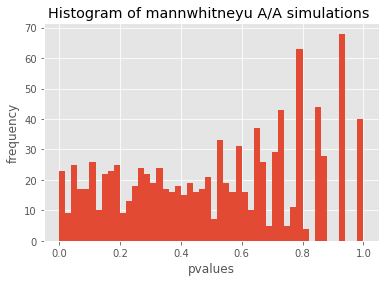

0.044

In [23]:
aa_test(df_0.query('version != "v2.8.0"').purchase,df.query('version != "v2.8.0"').purchase)

FPR < 0.05, ситуация значительно улучшилась.

## Вывод
Таким образом, можно сказать, что причина неправильной работы является сплит система: неверное деление на группы пользователей приложения версии v2.8.0. Конверсия в группе "0" была 0,1%, в то время как конверсия в группе "1" для этой же версии приложения была уже 4,56%.\
Без проблемной версии все работает значительно лучше и FRP находится в пределах нормы (FRP < 0.05).